## Example to run the plot_asso

### Directory structure of waveform data
#### SAC data (sac_parent_dir / date / (sac_dir_name) / station_name.SAC)
```
Hualien_0403/ -> sac_parent_dir     
└── 20240401/ -> date    
    └── merge_data -> sac_dir_name    
        ├── station_1.SAC -> station_name.SAC     
        └── station_2.SAC       
```
Especially for SAC reading rules, if your structure do not contain the subdir like sac_dir_name, you can input the sac_dir_name as empty string (sac_dir_name='').
#### HDF5 (h5_parent_dir / date / time_window.h5)
```
Hualien_0403_MiDAS/ -> h5_parent_dir     
└── 20240401/ -> date       
    ├── MiDAS_20240403_80700_81000.h5 -> time_window.h5     
    └── MiDAS_20240403_8100_8400.h5 
```
Date would acquire througth the reading of the gamma_events.csv from GaMMA.  
The reason why we need date is to automatically find the sac data due to we might have the events across the day.

### Scenarios (Seiemomter only, DAS only, Both)
#### Seismometer only

##### 1. Define the Path object

In [1]:
from pathlib import Path

# waveform dataset
sac_parent_dir = Path('/home/patrick/Work/Hualien0403/Dataset')
sac_dir_name = 'data_final'

# phasenet_picks
phasenet_picks = Path(
    '/home/patrick/Work/Hualien0403/PhaseNet_DAS/picks_phasenet_das/old_shit/bat_cwb_sm_20240403.csv'
)  

# gamma output
gamma_picks = Path(
    '/home/patrick/Work/Hualien0403/GaMMA/Results_all_seis/gamma_picks.csv'
) 
gamma_events = Path(
    '/home/patrick/Work/Hualien0403/GaMMA/Results_all_seis/daily/20240403.csv'
)

# station info
station = Path('/home/patrick/Work/EQNet/tests/hualien_0403/station_seis.csv')

# optional, if you want to see the result of relocation.
h3dd_hout = Path(
    '/home/patrick/Work/Hualien0403/H3DD/GaMMA_cutoff_3/daily_hout/20240403.hout'
)  

# figure save directory
figure_dir = Path('/home/patrick/Work/AutoQuake/test')

##### 2. format check
**Ensure that the listed column name of the following file is correct due to we use the pandas.DataFrame to access the data.**    
      
**Since we use the default output of PhaseNet and GaMMA, the column name should be the same, just check.**


***GaMMA event catalog: gamma_events.csv***      
- time: UTC time of the event, str
- event_index: index of the event, int
- longitude: longitude of the event, float
- latitude: latitude of the event, float
- depth_km: depth of the event, float

In [8]:
import pandas as pd
df_event = pd.read_csv(gamma_events)
df_event.head(2)

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km),longitude,latitude,depth_km
0,2024-04-03T00:00:18.811,999,0.613,0,0,16.475,12,6,6,1087,-7.836,-23.597,37.990,121.623,23.787,37.990
1,2024-04-03T00:00:57.764,999,0.554,0,0,18.000,17,8,9,1088,-6.989,22.633,27.292,121.631,24.204,27.292


***GaMMA associated picks: gamma_picks.csv***
- station_id: station id, str
- phase_time: UTC time of the phase, str
- phase_type: phase type, str
- event_index: index of the event, int

In [9]:
df_picks = pd.read_csv(gamma_picks)
df_picks.head(2)

,station_id,phase_time,phase_score,phase_type,event_index,gamma_score
0,TDCB,2024-04-01T01:38:49.478000,0.858,P,15707,0.291788
1,TDCB,2024-04-01T02:15:44.178000,0.737,P,-1,-1.000000


***staiton.csv (net is not important, just additional info)***
- station: station name, str
- longitude: longitude, float
- latitude: latitude, float
- elevation: elevation, float

In [10]:
df_station = pd.read_csv(station)
df_station.head(2)

,net,station,longitude,latitude,elevation
0,BATS,LATB,121.52640,24.53530,1020.0
1,BATS,GWUB,121.11314,24.50588,2159.0


***station additional check: Naming idiom***  
In plot_asso, we use the function **station_mask** as **default** to determine the station type.    
          
If you want to change the default, you can write your own function to determine the station type.     
     
In my cases, I use:

In [ ]:
def station_mask(x: str):
    return str(x)[1].isalpha()

Therefore, If True, type is seismometer (L"**A**"TB). If False, type is DAS (A"**1**"03).

***PhaseNet picks: picks.csv***   
- station_id: station id, str
- phase_index: index of the data points, int
- phase_time: UTC time of the phase, str
- phase_type: phase type, str

In [11]:
df_phase = pd.read_csv(phasenet_picks)
df_phase.head(2)

,station_id,begin_time,phase_index,phase_time,phase_score,phase_type,file_name,phase_amplitude,phase_amp
0,TW.LONT.00.HH,2024-04-03T00:00:00.000,108136,2024-04-03T00:18:01.360,0.627,P,TW.LONT.00.HH*,235471.062500,235471.062500
1,TW.LONT.00.HH,2024-04-03T00:00:00.000,164281,2024-04-03T00:27:22.810,0.336,P,TW.LONT.00.HH*,69958.210938,69958.210938


***PhaseNet data preprocessing***     
In here, because the value in station_id column is like 'TW.LONT.00.HH'.    
Therefore, I use lambda x: str(x).split('.')[1] as default to get the station name for subsequent analysis.    
     
If you want to change the default, you can write your own function to get the station name as follows:

In [ ]:
from autoquake.visualization.check_plot import preprocess_phasenet_csv

df_phasenet_picks = preprocess_phasenet_csv(
    phasenet_picks=phasenet_picks,
    get_station=lambda x: str(x).split('.')[1] # if you use default, you can ignore it.
)

#### 3. run it

/home/patrick/.conda/envs/AutoQuake_00/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/patrick/.conda/envs/AutoQuake_00/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/patrick/.conda/envs/AutoQuake_00/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/patrick/.conda/envs/AutoQuake_00/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/home/patrick/.conda/envs/AutoQuake_00/lib/python3.10/site-packages/cart

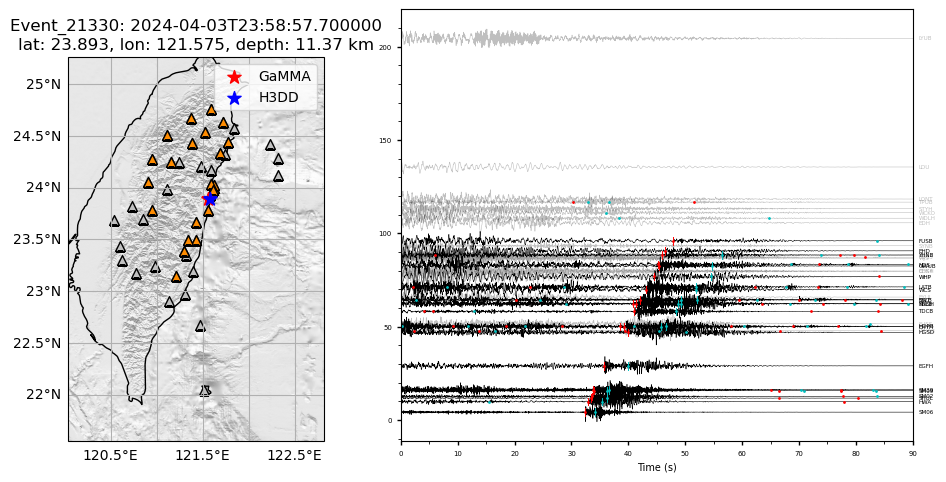

In [3]:
from autoquake.visualization.check_plot import plot_asso

plot_asso(
    df_phasenet_picks=df_phasenet_picks,
    gamma_picks=gamma_picks,
    gamma_events=gamma_events,
    station=station,
    event_i=21330, # example
    fig_dir=figure_dir,
    sac_parent_dir=sac_parent_dir,
    sac_dir_name=sac_dir_name,
    h3dd_hout=h3dd_hout,
    amplify_index=5, # if you use default, you can ignore it.
    station_mask=station_mask # if you use default, you can ignore it.
)

#### 3.1 multiprocessing (I haven't try that, but I think it's gonna work fine.)
If you want to accelarate the plotting, you can: 
1. set parallel=True (False is default).    
2. import preprocess_phasenet_csv function, and return the df_phasenet_picks as global variable for all processes.    
3. using multiprocessing.starmap to pack the function, the only variable you need to change is the event_i.

In [ ]:
import multiprocessing as mp
from autoquake.visualization.check_plot import preprocess_phasenet_csv
from functools import partial
import pandas as pd

df_event = pd.read_csv(gamma_events)
indices = set(df_event['event_index'])
df_all_picks = preprocess_phasenet_csv(phasenet_picks=phasenet_picks)

args_list = [(df_all_picks, gamma_picks, gamma_events, station, i, figure_dir) for i in indices]
my_plot_asso = partial(plot_asso, sac_parent_dir=sac_parent_dir, sac_dir_name=sac_dir_name, h3dd_hout=h3dd_hout, station_mask=station_mask)

# Parallel processing using multiprocessing.Pool and starmap
if __name__ == '__main__':
    # Create a pool of workers
    with mp.Pool() as pool:
        # Use starmap to pass arguments and run plot_asso in parallel
        pool.starmap(my_plot_asso, args_list)

#### DAS only

In [15]:
from pathlib import Path

phasenet_picks = Path('/home/patrick/Work/Hualien0403/PhaseNet_DAS/picks_phasenet_das/maineq_onlydas.csv')
gamma_events = Path('/home/patrick/Work/Hualien0403/GaMMA/gamma_test/main_eq_onlydas/gamma_events.csv')
gamma_picks = Path('/home/patrick/Work/Hualien0403/GaMMA/gamma_test/main_eq_onlydas/gamma_picks.csv')
station = Path('/home/patrick/Work/EQNet/tests/hualien_0403/station_das.csv')
h5_parent_dir = Path("/raid4/DAS_data/iDAS_MiDAS/hdf5/20240402_hdf5/")
figure_dir = Path('/home/patrick/Work/AutoQuake/test')

In [16]:
from autoquake.visualization.check_plot import preprocess_phasenet_csv

df_phasenet_picks = preprocess_phasenet_csv(
    phasenet_picks=phasenet_picks
)
df_phasenet_picks.head(2)

,station_id,phase_index,phase_time,phase_score,phase_type,total_seconds,station
0,MiDAS_86100_86400.A056,6139,2024-04-02 23:56:01.390,0.369,P,86161.39,A056
1,MiDAS_86100_86400.A056,6154,2024-04-02 23:56:01.540,0.370,P,86161.54,A056


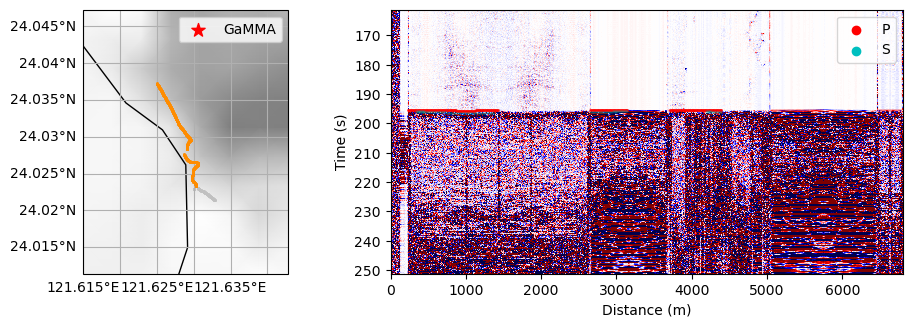

In [17]:
from autoquake.visualization.check_plot import plot_asso

plot_asso(
    df_phasenet_picks=df_phasenet_picks,
    gamma_picks=gamma_picks,
    gamma_events=gamma_events,
    station=station,
    event_i=19, # example
    fig_dir=figure_dir,
    h5_parent_dir=h5_parent_dir
)

##### Note
Event may exceed the map range in DAS data.     
     
However, the map view would not clear if we include the event.      
     
Therefore, the best way is to set the reasonable searching range for GaMMA, then the events would be included.

#### Both

In [4]:
from pathlib import Path

# waveform dataset
sac_parent_dir = Path('/home/patrick/Work/Hualien0403/Dataset')
sac_dir_name = 'data_final'
h5_parent_dir = Path("/raid4/DAS_data/iDAS_MiDAS/hdf5/20240403_hdf5/")

phasenet_picks = Path(
    '/home/patrick/Work/Hualien0403/PhaseNet_DAS/picks_phasenet_das/new_seis_das_picks.csv'
)  # noqa: E501
gamma_events = Path(
    '/home/patrick/Work/Hualien0403/GaMMA/gamma_test/test_5/gamma_events.csv'
)  # noqa: E501
gamma_picks = Path(
    '/home/patrick/Work/Hualien0403/GaMMA/gamma_test/test_5/gamma_clean_picks.csv'
)  # noqa: E501
station = Path('/home/patrick/Work/EQNet/tests/hualien_0403/new_das_seis_station.csv')
# dout_with_pol = Path(
#     '/home/patrick/Work/Hualien0403/GaMMA/gamma_test/test_5/for_gafocal_seis_das_new_261.dout'
# )  # noqa: E501
# dout_with_pol_index = Path(
#     '/home/patrick/Work/Hualien0403/GaMMA/gamma_test/test_5/for_gafocal_seis_das_new_261.dout_index'
# )  # noqa: E501
# gafocal = Path(
#     '/home/patrick/Work/AutoQuake/test_format/sd_new_261_gafocal_29249493_results.txt'
# )
h3dd_hout = Path(
    '/home/patrick/Work/Hualien0403/H3DD/GaMMA_das_seis_small_region/seis_das_new_0924_261.dat_ch.hout'
)
# figure save directory
figure_dir = Path('/home/patrick/Work/AutoQuake/test')

In [2]:
from autoquake.visualization.check_plot import preprocess_phasenet_csv

df_phasenet_picks = preprocess_phasenet_csv(
    phasenet_picks=phasenet_picks
)
df_phasenet_picks.head(2)

,station_id,phase_index,phase_time,phase_score,phase_type,total_seconds,station
0,TW.FUSS.00.HH,21161,2024-04-03 00:03:31.610,0.368,P,211.61,FUSS
1,TW.FUSS.00.HH,38359,2024-04-03 00:06:23.590,0.424,P,383.59,FUSS


/data2/patrick/AutoQuake/autoquake/visualization/check_plot.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seis_picks['x'] = (
/data2/patrick/AutoQuake/autoquake/visualization/check_plot.py:333: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seis_picks['y'] = df_seis_picks['station'].map(
/data2/patrick/AutoQuake/autoquake/visualization/check_plot.py:339: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

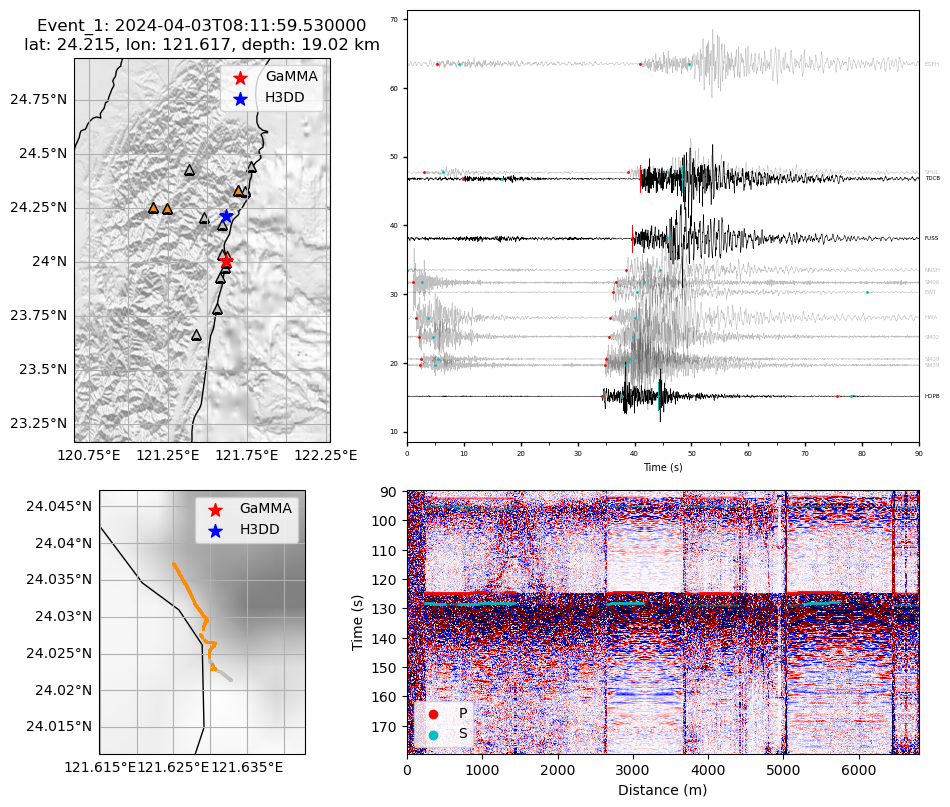

In [5]:
from autoquake.visualization.check_plot import plot_asso

plot_asso(
    df_phasenet_picks=df_phasenet_picks,
    gamma_picks=gamma_picks,
    gamma_events=gamma_events,
    station=station,
    event_i=1, # example
    fig_dir=figure_dir,
    sac_parent_dir=sac_parent_dir,
    sac_dir_name=sac_dir_name,
    h5_parent_dir=h5_parent_dir,
    h3dd_hout=h3dd_hout
)